In [1]:
from astropy.table import Table
import astropy.cosmology as cosmo
import bilby
import numpy as np
import healpy as hp
import pandas as pd

In [2]:
catalog = Table.read('data/catalog_fullsky_zsm1.fits.gz').to_pandas()

In [3]:
ra = catalog['RA'].values
dec = catalog['DEC'].values
z = catalog['REDSHIFT'].values

mask = (z<0.2) & (ra>0) & (ra<360) & (np.abs(dec)<90)

ra = ra[mask] * np.pi / 180
dec = dec[mask] * np.pi / 180
z = z[mask]

cosmology = cosmo.WMAP7
bilby.gw.cosmology.set_cosmology(cosmology=cosmology)

dl = bilby.gw.conversion.redshift_to_luminosity_distance(z)

100%0%


setting the output map dtype to [dtype('float64')]


HEALPix Map written to file


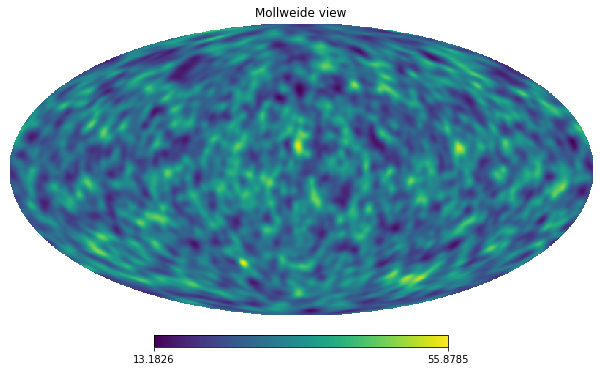

In [5]:
NSIDE = 2**10
NPIX = hp.nside2npix(NSIDE)
hp_map = np.zeros(NPIX)

size = 0.03

for i in range(len(z)):
    hp_map[hp.pixelfunc.ang2pix(NSIDE, 0.5 * np.pi - dec[i], ra[i])] += 1000
    if not i % 100:
        print("\r{}".format(np.round(100*(i+1)/len(z), 1)), end="%")

print("\r100%")

hp_map = hp.sphtfunc.smoothing(hp_map, sigma=size)

hp.fitsfunc.write_map('data/catalog_skymap.fits', hp_map, overwrite=True)
print("HEALPix Map written to file")

hp.mollview(hp_map)

In [10]:
sim_results = pd.DataFrame({
    'index':[],
    'id':[],
    'mass_1':[],
    'mass_2':[],
    'a_1':[],
    'a_2':[],
    'tilt_1':[],
    'tilt_2':[],
    'phi_12':[],
    'phi_jl':[],
    'luminosity_distance':[],
    'theta_jn':[],
    'psi':[],
    'phase':[],
    'geocent_time':[],
    'ra':[],
    'dec':[],
    'un_dl_med':[],
    'un_dl_upper':[],
    'un_dl_lower':[],
    'un_dl_avg':[],
    'un_dl_std':[],
    'un_ra_med':[],
    'un_ra_upper':[],
    'un_ra_lower':[],
    'un_ra_avg':[],
    'un_ra_std':[],
    'un_dec_med':[],
    'un_dec_upper':[],
    'un_dec_lower':[],
    'un_dec_avg':[],
    'un_dec_std':[],
    'hp_dl_med':[],
    'hp_dl_upper':[],
    'hp_dl_lower':[],
    'hp_dl_avg':[],
    'hp_dl_std':[],
    'hp_ra_med':[],
    'hp_ra_upper':[],
    'hp_ra_lower':[],
    'hp_ra_avg':[],
    'hp_ra_std':[],
    'hp_dec_med':[],
    'hp_dec_upper':[],
    'hp_dec_lower':[],
    'hp_dec_avg':[],
    'hp_dec_std':[],
})

sim_results.to_csv('data/sim_results.csv')

In [4]:
results = pd.read_csv('data/sim_results.csv')
results

,index,id,mass_1,mass_2,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,...,hp_ra_med,hp_ra_upper,hp_ra_lower,hp_ra_avg,hp_ra_std,hp_dec_med,hp_dec_upper,hp_dec_lower,hp_dec_avg,hp_dec_std
0,365528,HL1,30.217311,29.438553,0.751386,0.677525,0.41954,0.947159,5.605048,0.169506,...,4.005878,4.017005,3.993372,4.005418,0.01066,-0.800903,-0.794875,-0.802514,-0.79893,0.005455
